### Importing Libraries

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
data = yf.download("MU", start="2014-01-01", end=dt.date.today())
from importlib import reload
import matplotlib
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed


In [10]:
df=data.reset_index()
df = data['Close']
df = pd.DataFrame(df)
df_type = df.copy()
df.head()

,Close
Date,
2013-12-31,21.750000
2014-01-02,21.660000
2014-01-03,20.969999
2014-01-06,20.670000
2014-01-07,21.730000


In [11]:
#label 1 day ahead
df['Label']= df['Close'].shift(-1)
df

,Close,Label
Date,,
2013-12-31,21.750000,21.660000
2014-01-02,21.660000,20.969999
2014-01-03,20.969999,20.670000
2014-01-06,20.670000,21.730000
2014-01-07,21.730000,23.870001
...,...,...
2020-03-26,44.790001,43.480000
2020-03-27,43.480000,44.520000
2020-03-30,44.520000,42.060001


## Step 1

### Type 1 - feature Stochastic %K

In [12]:
#By using Rolling Mean, find out the 'Highest high price' and 'Lowest low price' of the Nikkei 225 index.
#Create the "Ln" column in the DataFrame
df['Ln'] = data['Low'].rolling(window=5).min()
#Create the "Hn" column in the DataFrame
df['Hn'] = data['High'].rolling(window=5).max()

#### Using technical indicators and formula no.1 (Type 1).[Stochastic %K->(Ct − Ln)/(Hn − Ln)×100],
#where (Ct= Closing price, Ln=Lowest low price, Hn= Highest high price)


In [13]:
#stochasticK=(data["Close"]-data["Ln"])/(data["Hn"]-data["Ln"])*100
StochasticK =(100*((data['Close'] - df['Ln']) / (df['Hn'] - df['Ln']) ))
df['StochasticK']= StochasticK.shift(-1)
StochasticK.dropna().head()

Date
2014-01-07    83.846092
2014-01-08    83.678781
2014-01-09    67.357512
2014-01-10    79.533658
2014-01-13    67.590031
dtype: float64

In [14]:
df.tail()

,Close,Label,Ln,Hn,StochasticK
Date,,,,,
2020-03-26,44.790001,43.480000,35.689999,45.75,77.435386
2020-03-27,43.480000,44.520000,35.689999,45.75,78.496516
2020-03-30,44.520000,42.060001,40.029999,45.75,35.489548
2020-03-31,42.060001,39.889999,40.029999,45.75,8.722706
2020-04-01,39.889999,NaN,39.330002,45.75,NaN


### Type 1 - feature OSCP

In [15]:
##Formula: OSCP (price oscillator)	MA5 − MA10/MA5
df['Close_MA5']= df['Close'].rolling(5).mean()
df['Close_MA10']= df['Close'].rolling(10).mean()
OSCP= df['Close_MA5'] - df["Close_MA10"]/df["Close_MA5"]
df['OSCP']= OSCP.shift(-1)
OSCP.dropna().head()

Date
2014-01-14    22.610851
2014-01-15    22.491726
2014-01-16    22.462548
2014-01-17    22.179308
2014-01-21    22.124919
dtype: float64

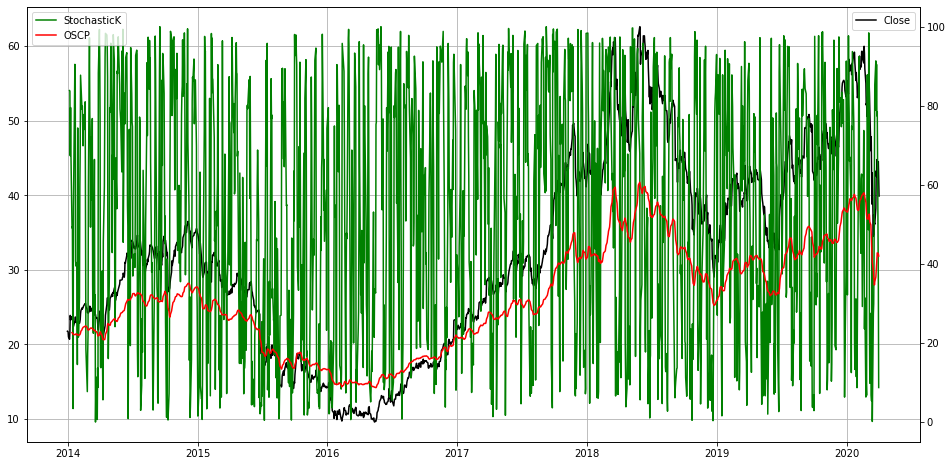

In [19]:
#Visualizing price and features in the same graph 

#Plotting

fig, ax = plt.subplots(figsize=(16, 8))
 
plt.plot(df['Close'], label='Close', color='black')
plt.legend(loc='upper right')
plt.grid()
 

# Get second axis
ax2 = ax.twinx() 
plt.plot(df['StochasticK'], label='StochasticK',color='green')
plt.plot(df['OSCP'], label='OSCP',color='red')
plt.legend(loc='upper left')
plt.show()

## Step 2

### Regression and Plot based on the features, forecast 1-day ahead

In [20]:
# Rename the Label
label1= df.shift(-1)
label1 = label1.rename({'Close':'Close_label', 'StochasticK':'StochasticK_label', 'OSCP':'OSCP_label'}, axis='columns')


In [21]:
#merged_table and drop NaN value
merged_table = pd.merge(df, label1, on='Date')
merged_table=merged_table.dropna()
df.tail()

,Close,Label,Ln,Hn,StochasticK,Close_MA5,Close_MA10,OSCP
Date,,,,,,,,
2020-03-26,44.790001,43.480000,35.689999,45.75,77.435386,40.984,39.074001,41.536548
2020-03-27,43.480000,44.520000,35.689999,45.75,78.496516,42.458,39.123000,42.793991
2020-03-30,44.520000,42.060001,40.029999,45.75,35.489548,43.712,40.128000,42.536115
2020-03-31,42.060001,39.889999,40.029999,45.75,8.722706,43.470,40.596000,41.990657
2020-04-01,39.889999,NaN,39.330002,45.75,NaN,42.948,41.116000,NaN


### StochasticK Regresssion

In [22]:
X_StochasticK = merged_table['StochasticK'].values
Y_StochasticK = merged_table['StochasticK_label'].values
X_StochasticK = X_StochasticK.reshape(-1,1)

In [23]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 5)
print(tscv) 

TimeSeriesSplit(max_train_size=None, n_splits=5)


In [24]:
for train_index, test_index in tscv.split(X_StochasticK):
    x_train,x_test = X_StochasticK[train_index],X_StochasticK[test_index]
    y_train,y_test = Y_StochasticK[train_index],Y_StochasticK[test_index]

In [25]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train, y_train)
Y_pred = regressor.predict(x_test)

In [26]:
StochasticK_X_test = x_test.copy()
StochasticK_Y_pred = Y_pred.copy()

In [27]:
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, ElasticNetCV, Ridge
from sklearn.neural_network import MLPRegressor

In [28]:
#Create sklearn's model to a variable
linear = ElasticNetCV()

In [29]:
# To make a fit or "train" the model and reshape just to avoid error warning
linear.fit(x_train, y_train.reshape(len(y_train),))

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [30]:
#Score returns the coefficient of determination R^2 of the prediction
linear.score(x_test, y_test)

0.3342001285236508

In [31]:
# predict () uses the model to predict the values for the input
forecast_StochasticK = linear.predict(x_test)
forecast_StochasticK[:5]

array([80.77854917, 50.32156516, 31.96702811, 28.74588777, 21.66206227])

In [32]:
# Now we can see what the actual labels were for the featuresets
y_test[:5]

array([48.81420154, 20.26144388, 15.25056078,  4.23079209,  7.38258928])

In [33]:
df1=pd.DataFrame(forecast_StochasticK.reshape(-1,1),\
                index=data.index[-len(forecast_StochasticK):], columns=["Forecast_StochasticK"])
df1["StochasticK_Test"]= y_test
df1.head()

,Forecast_StochasticK,StochasticK_Test
Date,,
2019-03-22,80.778549,48.814202
2019-03-25,50.321565,20.261444
2019-03-26,31.967028,15.250561
2019-03-27,28.745888,4.230792
2019-03-28,21.662062,7.382589


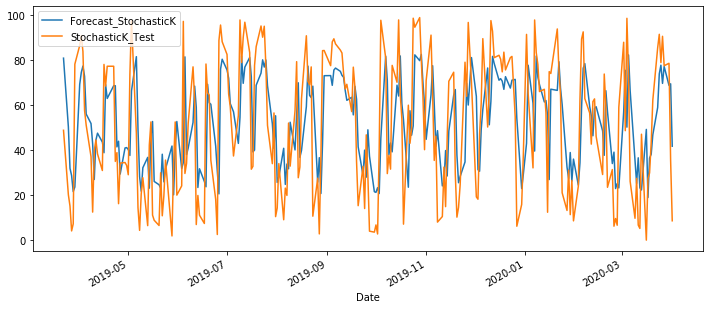

In [34]:
_=df1.plot(figsize=(12,5))

### OSCP Regresssion

In [35]:
X_oscp = merged_table['OSCP'].values
Y_oscp = merged_table['OSCP_label'].values
X_oscp = X_oscp.reshape(-1,1)

In [36]:
for train_index, test_index in tscv.split(X_oscp):
    x_train,x_test = X_oscp[train_index],X_oscp[test_index]
    y_train,y_test = Y_oscp[train_index],Y_oscp[test_index]

In [37]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train, y_train)
Y_pred = regressor.predict(x_test)

In [38]:
Oscp_X_test = x_test.copy()
Oscp_Y_pred = Y_pred.copy()

In [39]:
linear.fit(x_train, y_train.reshape(len(y_train),))

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [40]:
#Score returns the coefficient of determination R^2 of the prediction
linear.score(x_test, y_test)

0.9899040564416145

In [41]:
forecast_oscp = linear.predict(x_test)
forecast_oscp[:5]

array([39.73666679, 40.15429075, 40.34257796, 40.32978478, 40.14499843])

In [42]:
df2=pd.DataFrame(forecast_oscp.reshape(-1,1),\
                index=data.index[-len(forecast_oscp):], columns=["Forecast_OSCP"])
df2["OSCP_Test"]= y_test
df2.head()

,Forecast_OSCP,OSCP_Test
Date,,
2019-03-22,39.736667,40.169909
2019-03-25,40.154291,40.358662
2019-03-26,40.342578,40.345837
2019-03-27,40.329785,40.160594
2019-03-28,40.144998,39.205584


<IPython.core.display.Javascript object>


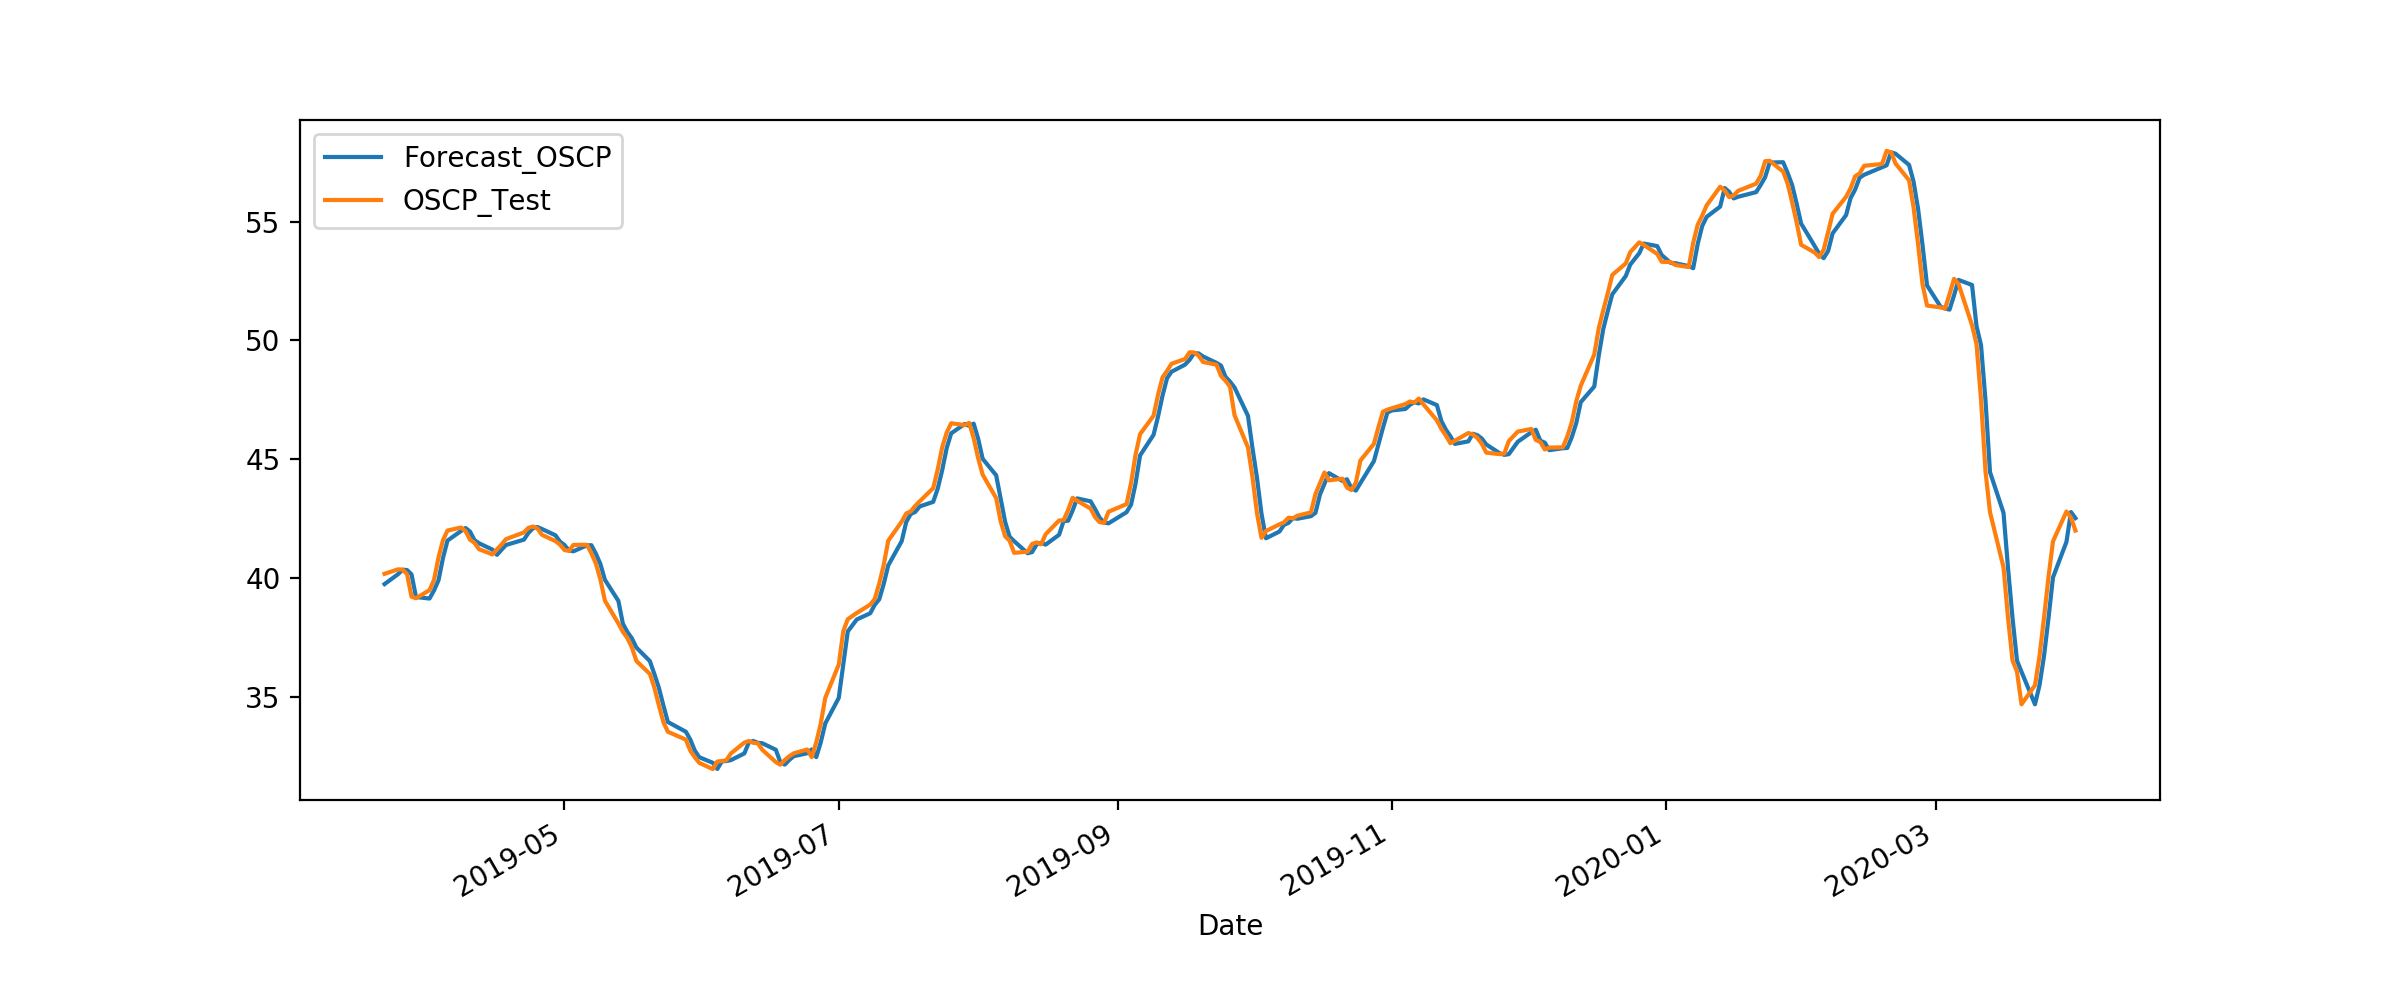

In [101]:
_=df2.plot(figsize=(12,5))

In [107]:
#restranform the scaled data to original data
new_shape=np.array(Scaler.inverse_transform(df1)).reshape(1,-1)[0]
test1=pd.Series(new_shape)
new_shape2=np.array(Scaler.inverse_transform(y_test)).reshape(1,-1)[0]
test2=pd.Series(new_shape2)
test_data=pd.DataFrame()
test_data=pd.concat([test2,test1], axis=1)
test_data.columns=['Expected Output','Forecasted']
test_data.head()

,Expected Output,Forecasted
0,0.895533,80.778549
1,0.716631,48.814202
2,0.635861,50.321565
3,0.618499,20.261444
4,0.536219,31.967028


In [110]:
df3 = pd.concat([df1, df2], axis=1, join='inner')

<IPython.core.display.Javascript object>


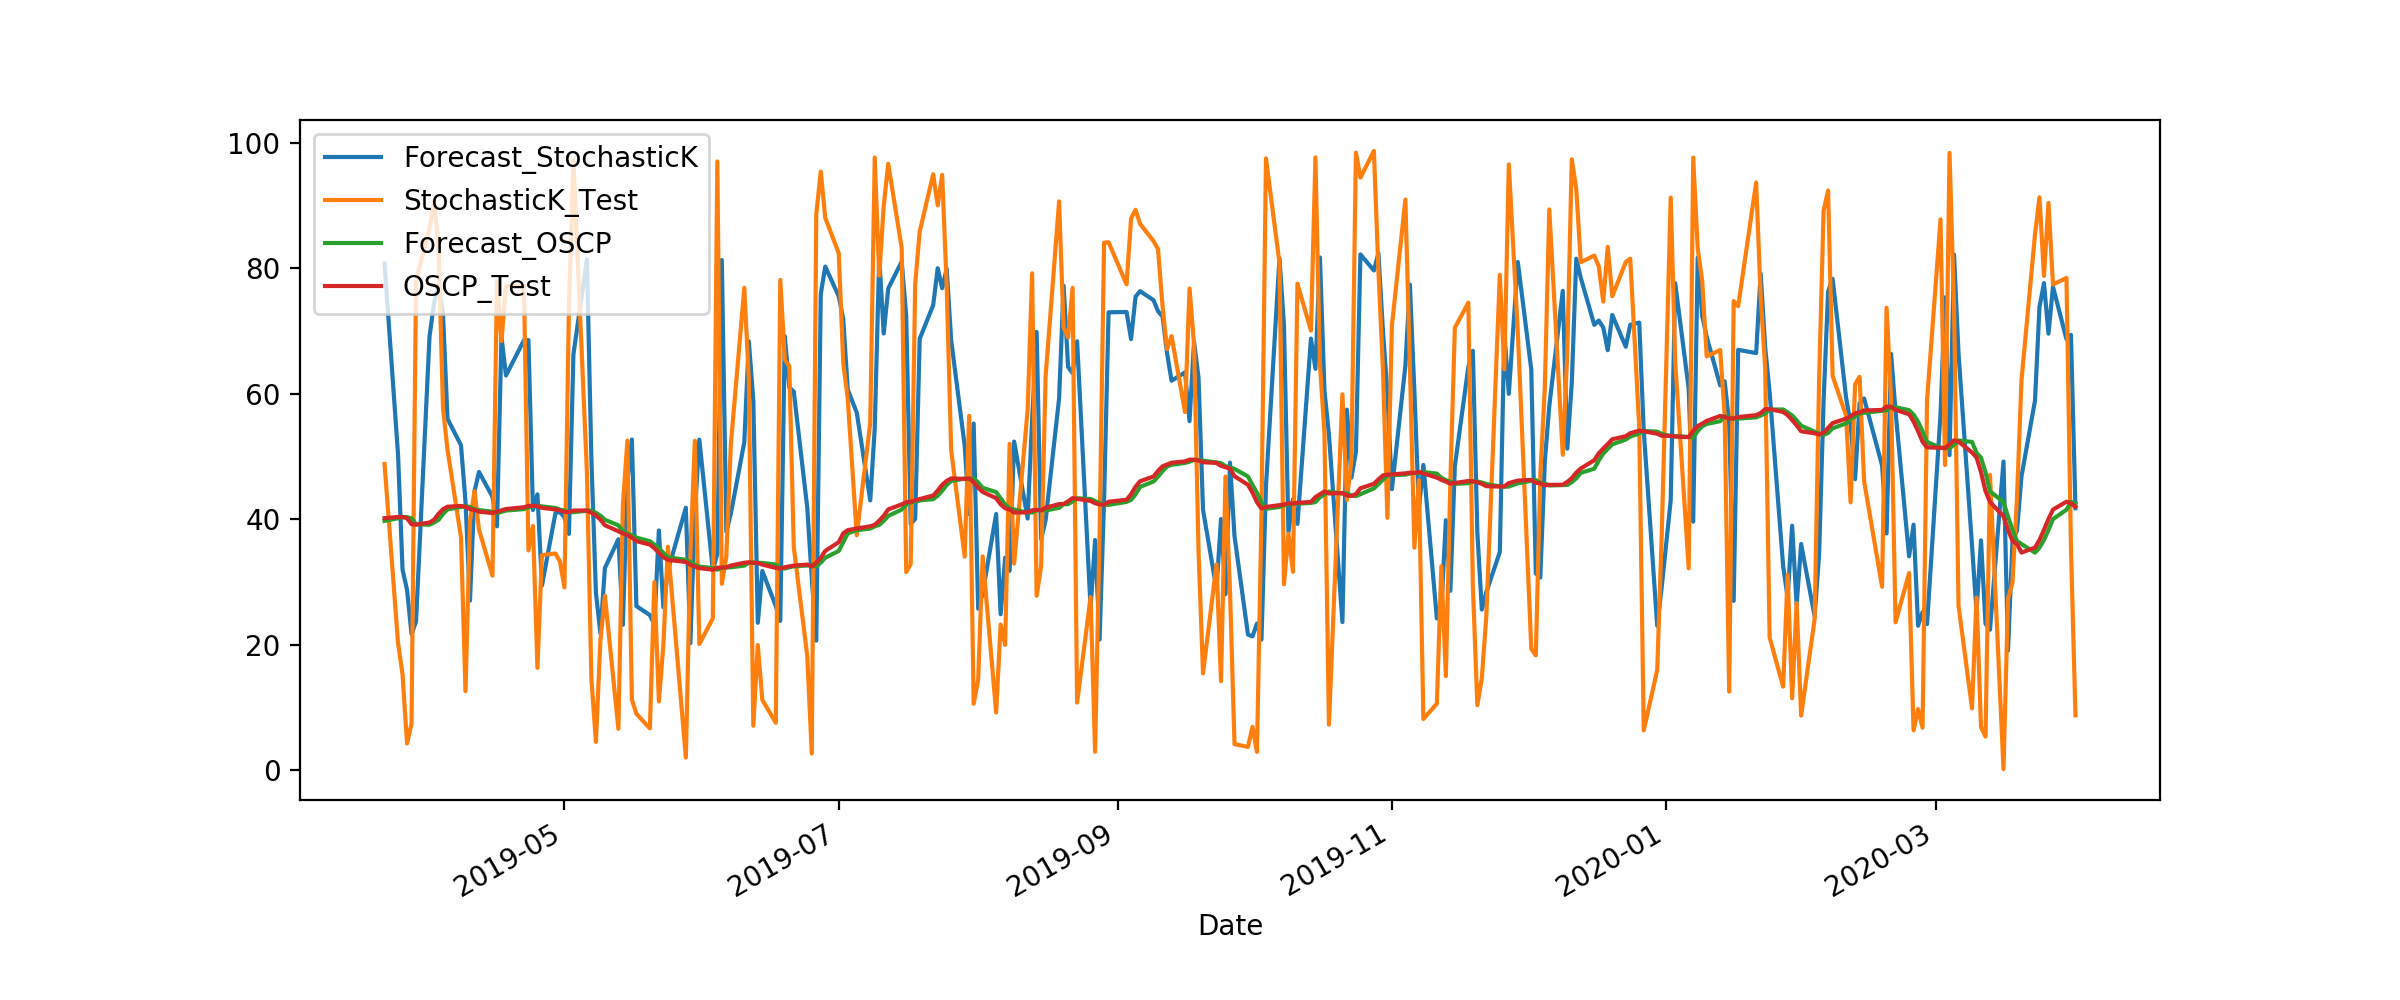

In [111]:
%matplotlib notebook
reload(plt)
subplot=df3.plot(figsize=(12,5))

## Step 3

### Type 2 - feature ASY1

In [112]:
lnCt = np.log(df_type)
lnCt_1 = lnCt.shift(-1)

SYt = lnCt - lnCt_1

In [113]:
ASY1 = SYt*100
df["ASY_1"] = ASY1

### Type 2 - feature ASY2

In [114]:
ASY2 = SYt.rolling(2).mean()
df["ASY_2"] = ASY2

In [115]:
df_type.dropna(inplace=True)

In [116]:
label2 = df.shift(-1)
label2 = label2.rename({'Close':'Close_label', 'ASY_1':'ASY_1_label', 'ASY_2':'ASY_2_label'}, axis='columns')

In [117]:
merged_table_t2 = pd.merge(df, label2, on='Date')
merged_table_t2=merged_table_t2.dropna()

In [118]:
df.tail()

,Close,Label,Ln,Hn,StochasticK,Close_MA5,Close_MA10,OSCP,ASY_1,ASY_2
Date,,,,,,,,,,
2020-03-26,44.790001,43.480000,35.689999,45.75,77.435386,40.984,39.074001,41.536548,2.968387,-0.011398
2020-03-27,43.480000,44.520000,35.689999,45.75,78.496516,42.458,39.123000,42.793991,-2.363748,0.003023
2020-03-30,44.520000,42.060001,40.029999,45.75,35.489548,43.712,40.128000,42.536115,5.684133,0.016602
2020-03-31,42.060001,39.889999,40.029999,45.75,8.722706,43.470,40.596000,41.990657,5.297155,0.054906
2020-04-01,39.889999,NaN,39.330002,45.75,NaN,42.948,41.116000,NaN,NaN,NaN


### Type 2 Regression

In [119]:
X_ASY1 = merged_table_t2['ASY_1'].values
Y_ASY1 = merged_table_t2['ASY_1_label'].values
X_ASY1 = X_ASY1.reshape(-1,1)

#X_train1,X_test1,Y_train1,Y_test1=train_test_split(X_ASY2, Y_ASY2, test_size=.2, random_state=0)
Xtrain = Ytrain = X_test = Y_test = Y_pred = 0
timeSeries = TimeSeriesSplit(n_splits=5)
for itrain, itest in timeSeries.split(X_ASY1):
    X_train,X_test = X_ASY1[itrain],X_ASY1[itest]
    Y_train,Y_test = Y_ASY1[itrain],Y_ASY1[itest]
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)

ASY1_X_test = X_test.copy()
ASY1_Y_pred = Y_pred.copy()

In [120]:
### X_ASY2 = merged_table_t2['ASY_2'].values
Y_ASY2 = merged_table_t2['ASY_2_label'].values
X_ASY2 = X_ASY2.reshape(-1,1)

#X_train1,X_test1,Y_train1,Y_test1=train_test_split(X_ASY2, Y_ASY2, test_size=.2, random_state=0)
Xtrain = Ytrain = X_test = Y_test = Y_pred = 0

for itrain, itest in timeSeries.split(X_ASY2):
    X_train, X_test = X_ASY2[itrain], X_ASY2[itest]
    Y_train, Y_test = Y_ASY2[itrain], Y_ASY2[itest]
    
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)

ASY2_X_test = X_test.copy()
ASY2_Y_pred = Y_pred.copy()

# Step 4

### Error for the regression;using sMAPE/MAPE and MASE error measurements

### MAPE

In [121]:
# Type 1 - Stochastic%K
StochasticK_data_x=pd.DataFrame(StochasticK_X_test)
StochasticK_data_y=pd.DataFrame(StochasticK_Y_pred)
MAPE_StochasticK = (abs(StochasticK_data_x - StochasticK_data_y)/abs(StochasticK_data_x)).sum()/len(StochasticK_data_x)*100
MAPE_StochasticK

0    104.387029
dtype: float64

In [122]:
# Type 1 - OSCP
Oscp_data_x=pd.DataFrame(Oscp_X_test)
Oscp_data_y=pd.DataFrame(Oscp_Y_pred)
MAPE_OSCP = (abs(Oscp_data_x - Oscp_data_y)/abs(Oscp_data_x)).sum()/len(Oscp_data_x)*100
MAPE_OSCP

0    0.019146
dtype: float64

In [123]:
# Type 2 - ASY 1
Asy1_data_x=pd.DataFrame(ASY1_X_test)
Asy1_data_y=pd.DataFrame(ASY1_Y_pred)

MAPE_Asy1 = (abs(Asy1_data_x - Asy1_data_y)/abs(Asy1_data_x)).sum()/len(Asy1_data_x)*100
MAPE_Asy1

0    inf
dtype: float64

In [124]:
# Type 2 - ASY 2
Asy2_data_x=pd.DataFrame(ASY2_X_test)
Asy2_data_y=pd.DataFrame(ASY2_Y_pred)

MAPE_Asy2 = (abs(Asy2_data_x - Asy2_data_y)/abs(Asy2_data_x)).sum()/len(Asy2_data_x)*100
MAPE_Asy2

0    49.784523
dtype: float64

### sMAPE

In [125]:
# Type 1 - Stochastic%K
sMAPE_StochasticK = 100/len(StochasticK_data_x) * np.sum(2 * np.abs(StochasticK_data_y - StochasticK_data_x) / (np.abs(StochasticK_data_x) + np.abs(StochasticK_data_y)))
sMAPE_StochasticK

0    30.063135
dtype: float64

In [126]:
# Type 1 - OSCP
sMAPE_OSCP = 100/len(Oscp_data_x) * np.sum(2 * np.abs(Oscp_data_y - Oscp_data_x) / (np.abs(Oscp_data_x) + np.abs(Oscp_data_y)))
sMAPE_OSCP

0    0.019144
dtype: float64

In [127]:
# Type 2 - ASY 1
sMAPE_Asy1 = 100/len(Asy1_data_x) * np.sum(2 * np.abs(Asy1_data_y - Asy1_data_x) / (np.abs(Asy1_data_x) + np.abs(Asy1_data_y)))
sMAPE_Asy1

0    176.852398
dtype: float64

In [128]:
# Type 2 - ASY 2
sMAPE_Asy2 = 100/len(Asy2_data_x) * np.sum(2 * np.abs(Asy2_data_y - Asy2_data_x) / (np.abs(Asy2_data_x) + np.abs(Asy2_data_y)))
sMAPE_Asy2

0    65.411857
dtype: float64

### MASE

In [129]:
#Type 1 - StochasticK
Errors = abs(StochasticK_data_x - StochasticK_data_y)
Difference = abs(StochasticK_data_y - StochasticK_data_x).sum()/StochasticK_data_x.size
MASE_StochasticK = (Errors/Difference).mean()
MASE_StochasticK

0    1.0
dtype: float64

In [130]:
#Type 1 - OSCP
Errors = Difference = 0
Errors = abs(Oscp_data_x- Oscp_data_y)
Difference = abs(Oscp_data_y - Oscp_data_x).sum()/Oscp_data_x.size
MASE_OSCP = (Errors/Difference).mean()
MASE_OSCP 

0    1.0
dtype: float64

In [131]:
# Type 2 - ASY 1
Errors = Difference = 0
Errors = abs(Asy1_data_x - Asy1_data_y)
Difference = abs(Asy1_data_y - Asy1_data_x).sum()/Asy1_data_x.size
MASE_Asy1 = (Errors/Difference).mean()
MASE_Asy1

0    1.0
dtype: float64

In [132]:
# Type 2 - ASY 2
Errors = Difference = 0
Errors = abs(Asy2_data_x - Asy2_data_y)
Difference = abs(Asy2_data_y - Asy2_data_x).sum()/Asy2_data_x.size
MASE_Asy2 = (Errors/Difference).mean()
MASE_Asy2

0    1.0
dtype: float64

## Step 5

### Decision based on regression.

In [133]:
Final_Data=pd.DataFrame()
Final_Data=df[['Close','StochasticK','OSCP','ASY_1','ASY_2','Label']]
#Final_Data3

In [134]:
x_model=np.array(Final_Data.drop(['Label'], 1))
y_model=np.array(Final_Data['Label'])

In [135]:
#STANDARD SCALING
from sklearn import preprocessing
y_model=y_model.reshape(-1,1)
Scaler = preprocessing.StandardScaler().fit(y_model)
x_model= Scaler.transform(x_model)
y_model=Scaler.transform(y_model)

In [136]:
#SPLITING THE DATA INTO 80% AND 20%
#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .20, random_state = 0)
from sklearn.model_selection import TimeSeriesSplit
tscv=TimeSeriesSplit(n_splits=5)
for train_index,test_index in tscv.split(x_model):
    x_train,x_test= x_model[train_index],x_model[test_index]
    y_train,y_test= y_model[train_index],y_model[test_index]

### Decison Design

In [138]:
test_data['Signal']=(test_data['Forecasted']-test_data['Expected Output']).dropna()
test_data['Signal']=np.sign(test_data['Signal']).dropna()
test_data.head()

,Expected Output,Forecasted,Signal
0,0.895533,80.778549,1.0
1,0.716631,48.814202,1.0
2,0.635861,50.321565,1.0
3,0.618499,20.261444,1.0
4,0.536219,31.967028,1.0


In [139]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
inp =np.array(test_data['Expected Output'])
inp=inp.reshape(-1,1)
lab=np.array(test_data['Signal'])

In [146]:
# Short term and long term averages setting
short_window = 40
long_window = 100
df["signal"]=0.0
df["short"] = df["Close"].rolling(window = short_window, min_periods=1, center=False).mean()
df["long"] = df["Close"].rolling(window = long_window, min_periods=1, center=False).mean()
df["signal"][short_window:]=np.where(df["short"][short_window:]>df["long"][short_window:],1.0,0.0)
df["positions"] = df["signal"].diff()
df.head()

,Close,Label,Ln,Hn,StochasticK,Close_MA5,Close_MA10,OSCP,ASY_1,ASY_2,signal,short,long,positions
Date,,,,,,,,,,,,,,
2013-12-31,21.750000,21.660000,NaN,NaN,NaN,NaN,NaN,NaN,0.414652,NaN,0.0,21.7500,21.7500,NaN
2014-01-02,21.660000,20.969999,NaN,NaN,NaN,NaN,NaN,NaN,3.237442,0.018260,0.0,21.7050,21.7050,0.0
2014-01-03,20.969999,20.670000,NaN,NaN,NaN,NaN,NaN,NaN,1.440943,0.023392,0.0,21.4600,21.4600,0.0
2014-01-06,20.670000,21.730000,NaN,NaN,83.846092,NaN,NaN,NaN,-5.001040,-0.017800,0.0,21.2625,21.2625,0.0
2014-01-07,21.730000,23.870001,20.639999,21.940001,83.678781,21.356,NaN,NaN,-9.392870,-0.071970,0.0,21.3560,21.3560,0.0


<IPython.core.display.Javascript object>


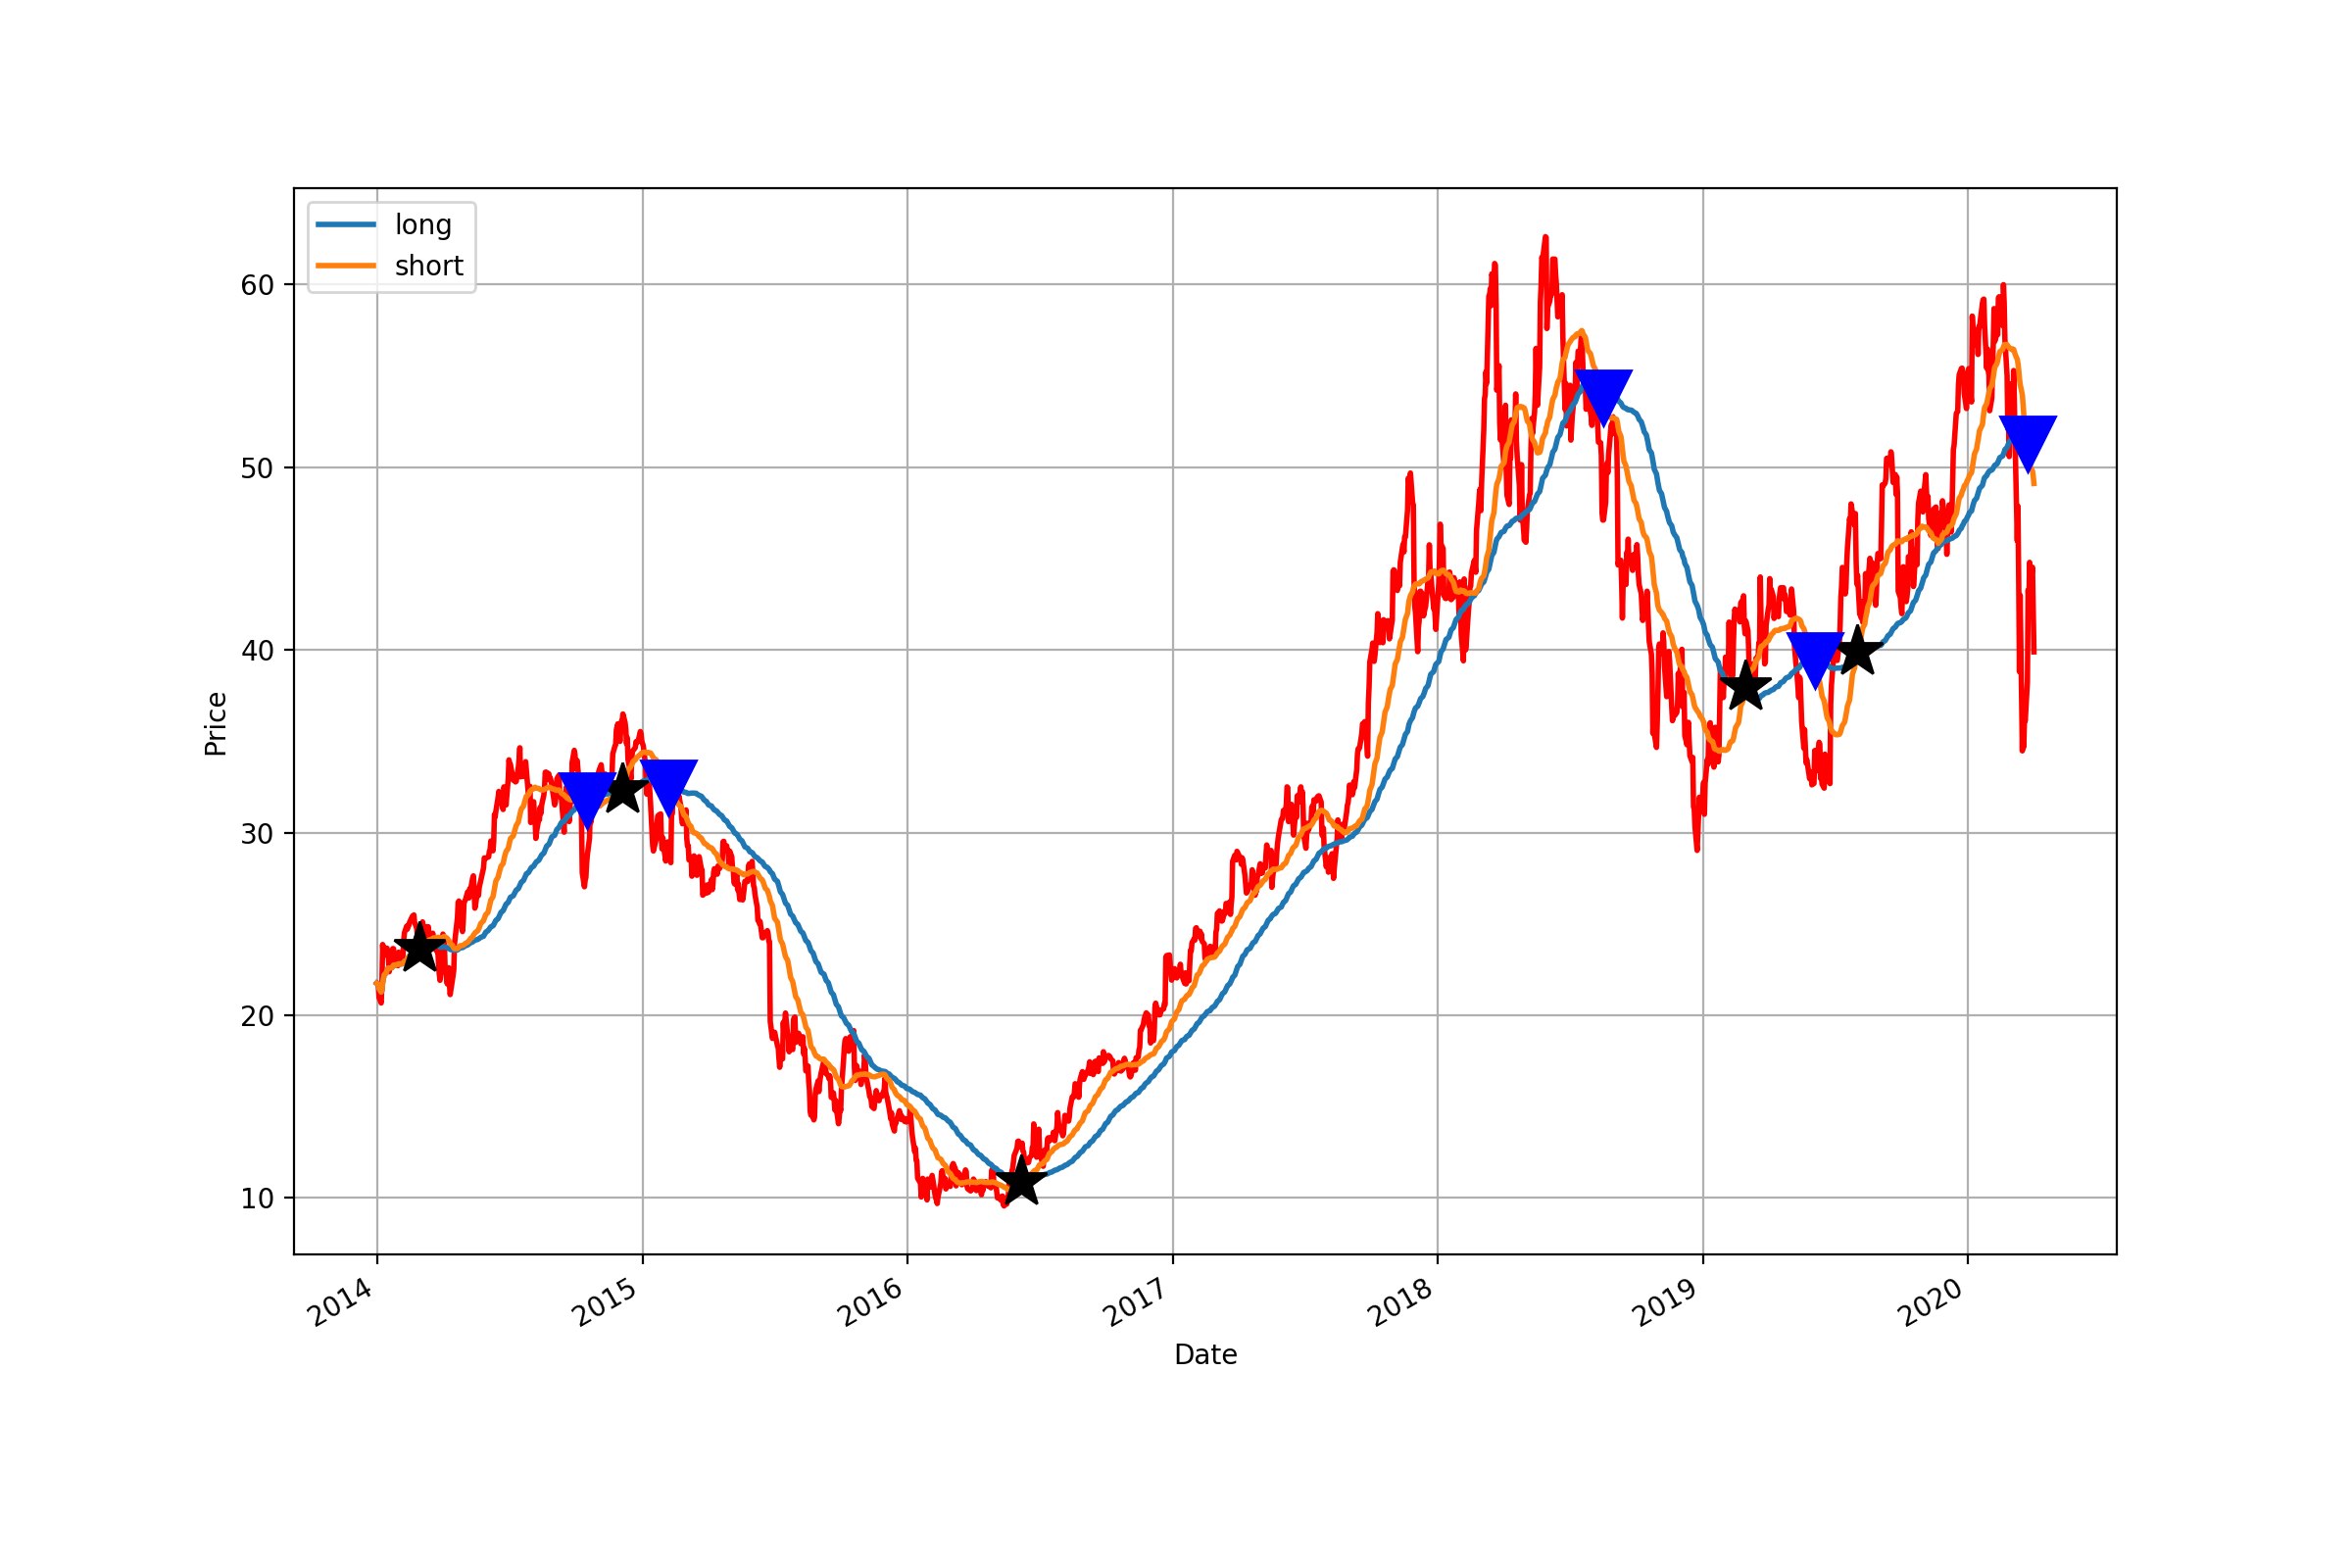

In [148]:
fig = plt.figure(figsize=(12,8))
# subplot and labels
ax1 = fig.add_subplot(111, ylabel='Price')
# plot prices
df['Close'].plot(ax=ax1, color='r', lw=2.)
# plot the moving averages
df[["long","short"]].plot(ax=ax1, lw=2.)
# plot the buy signals
ax1.plot(df.loc[df.positions == 1.0].index, df.short[df.positions == 1.0], '*', markersize=20, color='black')
# plot the sell signals
ax1.plot(df.loc[df.positions == -1.0].index, df.long[df.positions == -1.0], 'v', markersize=20, color='b')
plt.grid()
plt.show()